<a href="https://colab.research.google.com/github/wangyuanfudan/final-report/blob/main/%E9%A2%84%E8%AE%AD%E7%BB%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import models
from torchvision import datasets, transforms
from datetime import datetime
import sys
from tqdm import tqdm
#from utils import get_mean_and_std
import matplotlib.pyplot as plt

In [ ]:
print(sys.version_info)
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)
2.0.1+cu118
0.15.2+cu118
True
Tesla T4


In [ ]:
model = models.resnet18(pretrained=False, num_classes=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model = models.resnet18(pretrained=True, )
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 242MB/s]


In [ ]:
from torchsummary import summary

In [ ]:
summary(model, input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

设置模型的参数

In [ ]:
classes = ('plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')

In [ ]:
num_classes = 10

# hyper
batch_size = 64
num_epochs = 5
learning_rate = 1e-3

# gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
train_dataset = datasets.CIFAR10(root='../data/',
                               download=True,
                               train=True,
                               transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root='../data/',
                               download=True,
                               train=False,
                               transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:13<00:00, 12871107.05it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data/
Files already downloaded and verified


In [ ]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

In [ ]:
train_dataset = datasets.CIFAR10(root='../data/',
                               download=True,
                               train=True,
                               transform=transform)
test_dataset = datasets.CIFAR10(root='../data/',
                               download=True,
                               train=False,
                               transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               shuffle=True,
                                               batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               shuffle=False,
                                               batch_size=batch_size)

In [ ]:
images, labels = next(iter(train_dataloader))

In [ ]:
images.shape

torch.Size([64, 3, 224, 224])

In [ ]:
model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 10)
model = model.to(device)

fine tune

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimzier = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9,weight_decay=5e-4)
total_batch = len(train_dataloader)

In [ ]:
for epoch in range(num_epochs):
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # forward
        out = model(images)
        loss = criterion(out, labels)

        # 标准的处理，用 validate data；这个过程是监督训练过程，用于 early stop
        n_corrects = (out.argmax(axis=1) == labels).sum().item()
        acc = n_corrects/labels.size(0)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()   # 更细 模型参数

        if (batch_idx+1) % 100 == 0:
            print(f'{datetime.now()}, {epoch+1}/{num_epochs}, {batch_idx+1}/{total_batch}: {loss.item():.4f}, acc: {acc}')

2023-07-01 07:30:52.936304, 1/5, 100/782: 0.7956, acc: 0.734375
2023-07-01 07:31:10.355990, 1/5, 200/782: 0.5476, acc: 0.765625
2023-07-01 07:31:29.206269, 1/5, 300/782: 0.3418, acc: 0.90625
2023-07-01 07:31:46.926527, 1/5, 400/782: 0.2903, acc: 0.921875
2023-07-01 07:32:05.203241, 1/5, 500/782: 0.2826, acc: 0.90625
2023-07-01 07:32:23.027428, 1/5, 600/782: 0.4701, acc: 0.828125
2023-07-01 07:32:40.983772, 1/5, 700/782: 0.2028, acc: 0.953125
2023-07-01 07:33:13.255430, 2/5, 100/782: 0.0719, acc: 1.0
2023-07-01 07:33:31.425640, 2/5, 200/782: 0.2583, acc: 0.9375
2023-07-01 07:33:49.317175, 2/5, 300/782: 0.1337, acc: 0.9375
2023-07-01 07:34:07.463473, 2/5, 400/782: 0.1984, acc: 0.9375
2023-07-01 07:34:25.352042, 2/5, 500/782: 0.0825, acc: 0.984375
2023-07-01 07:34:43.544460, 2/5, 600/782: 0.0851, acc: 0.984375
2023-07-01 07:35:01.464532, 2/5, 700/782: 0.1298, acc: 0.96875
2023-07-01 07:35:34.583042, 3/5, 100/782: 0.1318, acc: 0.953125
2023-07-01 07:35:52.719076, 3/5, 200/782: 0.1208, acc:

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [ ]:
unnormalize = UnNormalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [ ]:
total = 0
correct = 0

all_mis_preds = []
all_mis_labels = []
all_mis_images = []

for images, labels in tqdm(test_dataloader):
    images = images.to(device)
    labels = labels.to(device)
    out = model(images)
    preds = torch.argmax(out, dim=1)
    total += images.size(0)
    correct += (preds == labels).sum().item()

    mis_preds_indice = torch.flatten((preds != labels).nonzero())
    mis_preds = preds[mis_preds_indice]
    mis_labels = labels[mis_preds_indice]
    mis_images = images[mis_preds_indice]

    all_mis_preds.extend(mis_preds)
    all_mis_labels.extend(mis_labels)

    for i in range(mis_images.size(0)):
        all_mis_images.append(unnormalize(mis_images[i]))

print(f'{correct}/{total}={correct/total}')

100%|██████████| 157/157 [00:31<00:00,  4.95it/s]

9412/10000=0.9412


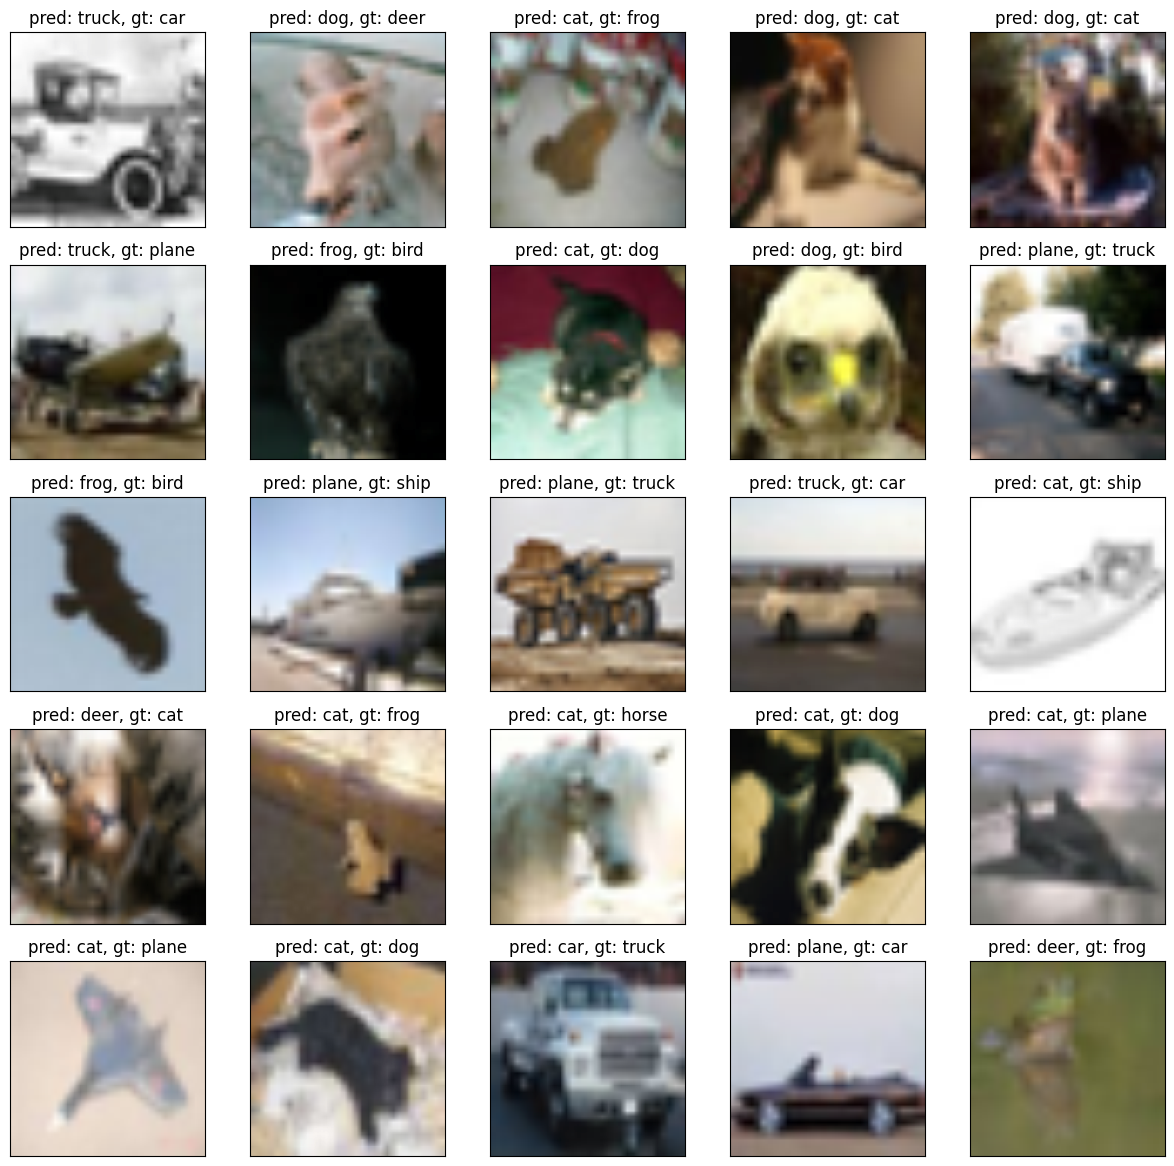

In [ ]:
import numpy as np
fig = plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.tight_layout()
    plt.imshow(np.transpose(all_mis_images[i].cpu(), (1, 2, 0)), interpolation='none')
    plt.title("pred: {}, gt: {}".format(classes[all_mis_preds[i].item()], classes[all_mis_labels[i].item()]))
    plt.xticks([])
    plt.yticks([])

In [ ]:
torch.save(model.state_dict(), 'resnet18_cifar10.ckpt')